In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest
from src.simple_wash_detector_utils import detect_wash_trades_local

import warnings
warnings.filterwarnings("ignore")

In [4]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)

df_all["notional"] = df_all["price"] * df_all["size"]
df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
df_all = df_all.drop("notional", axis=1)

In [5]:
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)
df_all["date"] = pd.to_datetime(df_all["time"], utc=True).dt.date
df_all["hour"] = df_all.time.dt.hour
df_all["date_hour"] = df_all["date"].astype("str") + df_all["hour"].astype("str")

df_all["round_size"] = df_all["size"].map(lambda x: round(x, 2))
# Per-wallet aggregates
wallet_stats = (
    df_all
    .groupby("wallet_id")
    .agg(
        n_trades=("size", "count"),
        avg_size=("size", "mean"),
        median_size=("size", "median"),
        std_size=("size", "std"),
        unique_dates=("date", "nunique"),
    )
)
wallet_stats = wallet_stats.dropna()

wallet_stats["trades_per_day"] = wallet_stats["n_trades"] / wallet_stats["unique_dates"]
wallet_stats["size_burstiness"] = wallet_stats["std_size"] / (wallet_stats["avg_size"] + 1e-10)
wallet_stats

,n_trades,avg_size,median_size,std_size,unique_dates,trades_per_day,size_burstiness
wallet_id,,,,,,,
1,69,69.565216,47.049999,285.302948,2,34.500000,4.101230e+00
3,3937,180.847824,84.989998,273.010529,66,59.651515,1.509615e+00
5,2156,47.063908,23.395000,51.910038,67,32.179104,1.102969e+00
6,3275,48.900211,19.040001,56.465569,97,33.762887,1.154710e+00
7,5523,39.259502,12.320000,51.657661,121,45.644628,1.315800e+00
...,...,...,...,...,...,...,...
271551,2,36.129997,36.129999,0.000003,1,2.000000,7.465814e-08
271895,12,53.143337,50.515001,18.827892,2,6.000000,3.542851e-01
272337,2,59.660004,59.660002,0.000003,2,1.000000,4.521284e-08


In [6]:
def inter_direction_times(group):
    directions = group['is_ask'].values
    times = group['time'].values
    change_idx = np.where(directions[1:] != directions[:-1])[0]

    if len(change_idx) == 0:
        return pd.Series({
            'inter_dir_q25': np.nan,
            'inter_dir_q75': np.nan,
            'inter_dir_gaps': []
        })

    gaps = (times[change_idx + 1] - times[change_idx]) / np.timedelta64(1, 's')

    q25, q75 = np.percentile(gaps, [25, 75]) if len(gaps) > 0 else (np.nan, np.nan)
    return pd.Series({
        'inter_dir_q25': q25,
        'inter_dir_q75': q75,
        'inter_dir_gaps': [gaps]
    })

def burstiness_ci(gaps, n_boot=200):
    # Flatten list of arrays to one vector
    if not isinstance(gaps, (list, np.ndarray)) or len(gaps) == 0:
        return pd.Series({'burstiness': np.nan})
    x = np.array(gaps).flatten()
    x = x[~np.isnan(x)]
    if len(x) < 3:
        return pd.Series({'burstiness': np.nan})

    mean, std = np.mean(x), np.std(x)
    if mean == 0:
        return pd.Series({'burstiness': np.nan})

    burst = std / mean

    return pd.Series({
        'burstiness': burst
    })


inter_dir_features = (
    df_all.groupby('wallet_id')
    .apply(inter_direction_times)
    .reset_index()
)

burst_features = inter_dir_features[['wallet_id', 'inter_dir_gaps']].copy()
burst_features = burst_features.join(
    burst_features['inter_dir_gaps'].apply(burstiness_ci)
)
burst_features = burst_features.drop(columns=['inter_dir_gaps']).rename({"burstiness": "time_burstiness"}, axis=1)
wallet_stats = pd.merge(
    wallet_stats.reset_index(),
    burst_features,
    on="wallet_id",
    how="inner"
)

In [7]:
from scipy.stats import entropy

def hourly_entropy(x):
    counts = x.value_counts(normalize=True)
    return entropy(counts, base=np.e)

hourly_entropy_feature = (
    df_all.groupby('wallet_id')['hour']
    .apply(hourly_entropy)
    .rename('hourly_activity_entropy')
    .reset_index()
)

wallet_stats = pd.merge(
    wallet_stats,
    hourly_entropy_feature,
    on="wallet_id",
    how="inner"
)

In [8]:
def compute_counterparty_entropy(df_matched):
    df = df_matched[['seller', 'buyer', 'size']].copy()

    seller_grouped = df.groupby(['seller', 'buyer'], as_index=False)['size'].sum()

    def entropy(series):
        p = series / series.sum()
        return -(p * np.log(p)).sum()

    seller_entropy = (
        seller_grouped.groupby('seller')['size']
        .apply(entropy)
        .reset_index(name='seller_entropy')
    )

    buyer_grouped = df.groupby(['buyer', 'seller'], as_index=False)['size'].sum()

    buyer_entropy = (
        buyer_grouped.groupby('buyer')['size']
        .apply(entropy)
        .reset_index(name='buyer_entropy')
    )

    entropy_features = (
        pd.merge(seller_entropy, buyer_entropy, left_on='seller', right_on='buyer', how='outer')
        .rename(columns={'seller': 'wallet_id'})
    )

    entropy_features['wallet_id'] = entropy_features['wallet_id'].fillna(entropy_features['buyer'])
    entropy_features = entropy_features[['wallet_id', 'seller_entropy', 'buyer_entropy']]

    entropy_features = entropy_features.fillna(0)

    entropy_features['total_entropy'] = entropy_features['seller_entropy'] + entropy_features['buyer_entropy']

    return entropy_features[["wallet_id", "total_entropy"]]

entropy_df = compute_counterparty_entropy(df_all_matched)

wallet_stats = pd.merge(
    wallet_stats,
    entropy_df,
    on="wallet_id",
    how="inner"
)

In [9]:
wallet_stats

,wallet_id,n_trades,avg_size,median_size,std_size,unique_dates,trades_per_day,size_burstiness,time_burstiness,hourly_activity_entropy,total_entropy
0,1,69,69.565216,47.049999,285.302948,2,34.500000,4.101230e+00,NaN,0.769738,4.632475
1,3,3937,180.847824,84.989998,273.010529,66,59.651515,1.509615e+00,4.073870,3.005802,8.353945
2,5,2156,47.063908,23.395000,51.910038,67,32.179104,1.102969e+00,8.781987,3.111425,7.882136
3,6,3275,48.900211,19.040001,56.465569,97,33.762887,1.154710e+00,2.196128,3.115243,7.082325
4,7,5523,39.259502,12.320000,51.657661,121,45.644628,1.315800e+00,2.611751,3.132419,7.862364
...,...,...,...,...,...,...,...,...,...,...,...
10064,271551,2,36.129997,36.129999,0.000003,1,2.000000,7.465814e-08,NaN,0.693147,0.654575
10065,271895,12,53.143337,50.515001,18.827892,2,6.000000,3.542851e-01,1.152154,1.583258,3.151694
10066,272337,2,59.660004,59.660002,0.000003,2,1.000000,4.521284e-08,NaN,0.693147,1.386270
10067,272404,2,959.900024,959.900024,0.000000,1,2.000000,0.000000e+00,NaN,0.000000,3.277726


In [10]:
group_median = wallet_stats[(wallet_stats["time_burstiness"] > 1.1) & (wallet_stats["time_burstiness"] < 1.5) & (wallet_stats["n_trades"] > 2) & (wallet_stats["n_trades"] < 20)]["time_burstiness"].median()

wallet_stats["time_burstiness"] = wallet_stats["time_burstiness"].fillna(group_median)

In [11]:
df_features = wallet_stats.copy()

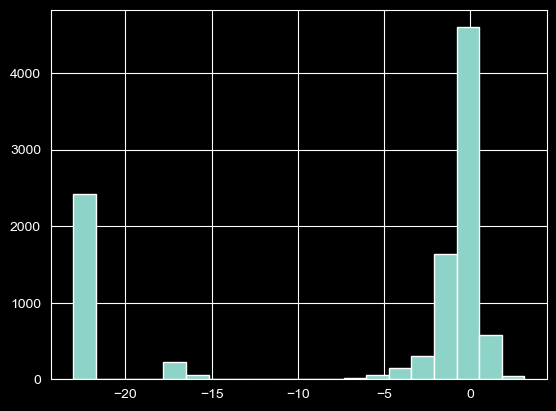

In [12]:
df_features["size_burstiness"] = np.log(df_features["size_burstiness"] + 1e-10)
df_features["size_burstiness"].hist(bins=20)
plt.show()

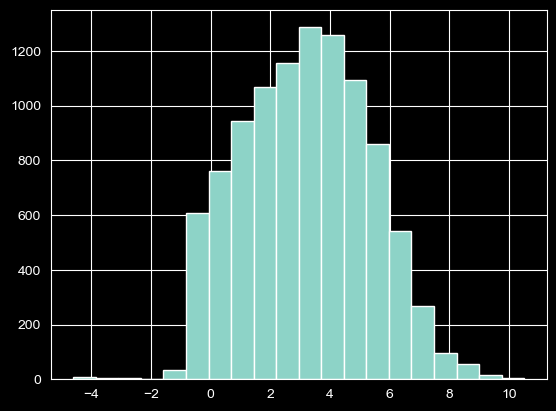

In [13]:
df_features["avg_size"] = np.log(df_features["avg_size"])
df_features["avg_size"].hist(bins=20)
plt.show()

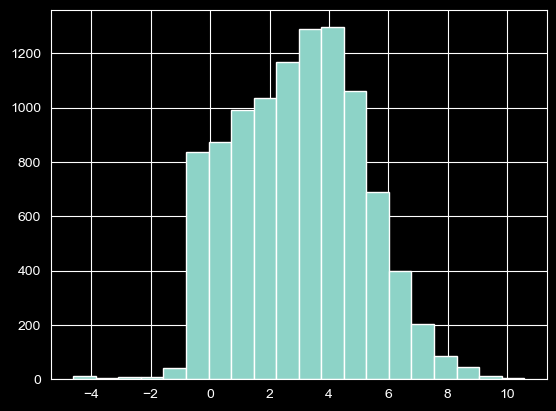

In [14]:
df_features["median_size"] = np.log(df_features["median_size"])
df_features["median_size"].hist(bins=20)
plt.show()

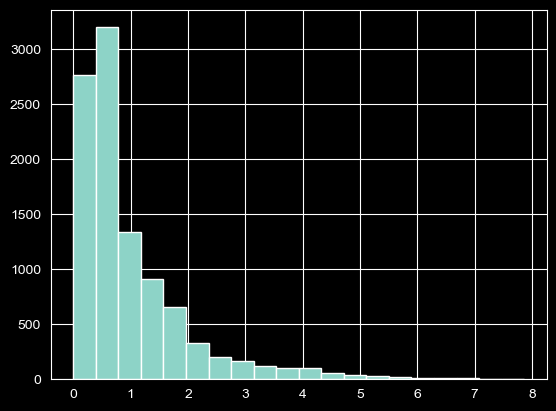

In [15]:
df_features["trades_per_day"] = np.log(df_features["trades_per_day"])
df_features["trades_per_day"].hist(bins=20)
plt.show()

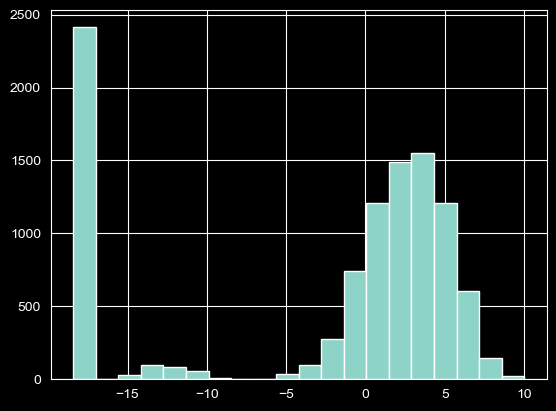

In [16]:
df_features["std_size"] = np.log(df_features["std_size"] + 1e-8)
df_features["std_size"].hist(bins=20)
plt.show()

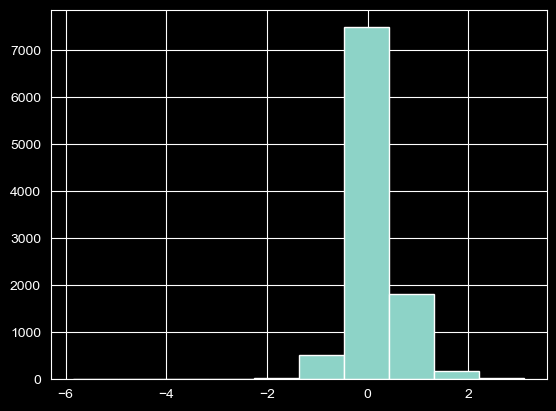

In [17]:
df_features["time_burstiness"] = np.log(df_features["time_burstiness"])
df_features["time_burstiness"].hist()
plt.show()

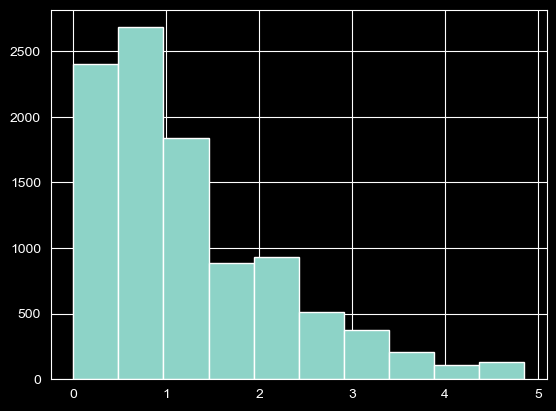

In [18]:
df_features["unique_dates"] = np.log(df_features["unique_dates"])
df_features["unique_dates"].hist()
plt.show()

In [19]:
df_features.set_index("wallet_id")

,n_trades,avg_size,median_size,std_size,unique_dates,trades_per_day,size_burstiness,time_burstiness,hourly_activity_entropy,total_entropy
wallet_id,,,,,,,,,,
1,69,4.242265,3.851211,5.653552,0.693147,3.540959,1.411287,0.267423,0.769738,4.632475
3,3937,5.197656,4.442534,5.609510,4.189655,4.088520,0.411854,1.404593,3.005802,8.353945
5,2156,3.851506,3.152522,3.949512,4.204693,3.471317,0.098006,2.172703,3.111425,7.882136
6,3275,3.889782,2.946542,4.033631,4.574711,3.519362,0.143849,0.786696,3.115243,7.082325
7,5523,3.670193,2.511224,3.944638,4.795791,3.820886,0.274445,0.960021,3.132419,7.862364
...,...,...,...,...,...,...,...,...,...,...
271551,2,3.587123,3.587124,-12.819523,0.000000,0.693147,-16.409008,0.267423,0.693147,0.654575
271895,12,3.972993,3.922270,2.935339,0.693147,1.791759,-1.037653,0.141633,1.583258,3.151694
272337,2,4.088662,4.088662,-12.819523,0.693147,0.000000,-16.909676,0.267423,0.693147,1.386270


In [20]:
corr_spearman = df_features.drop("wallet_id", axis=1).corr(method='spearman')
corr_pearson = df_features.drop("wallet_id", axis=1).corr(method='pearson')

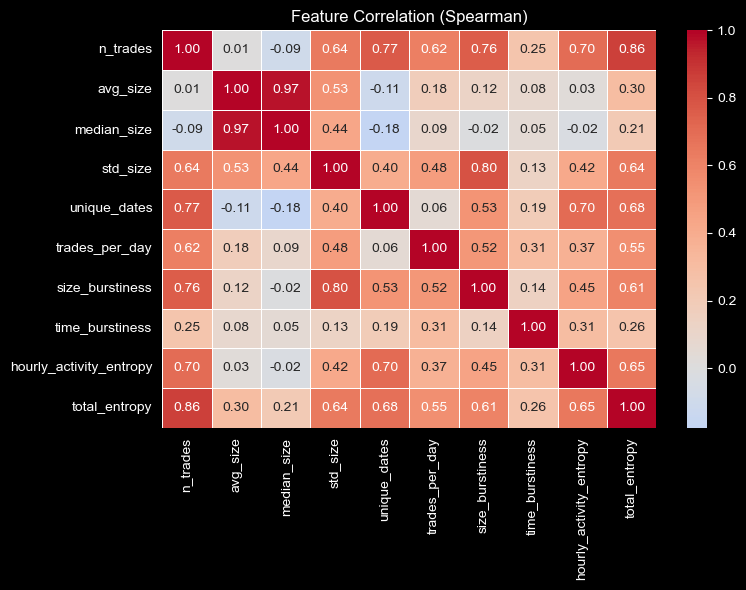

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman,
            annot=True,       # show correlation values
            cmap='coolwarm',  # color gradient
            center=0,         # white = no correlation
            linewidths=0.5,
            fmt=".2f")

plt.title("Feature Correlation (Spearman)")
plt.tight_layout()
plt.show()


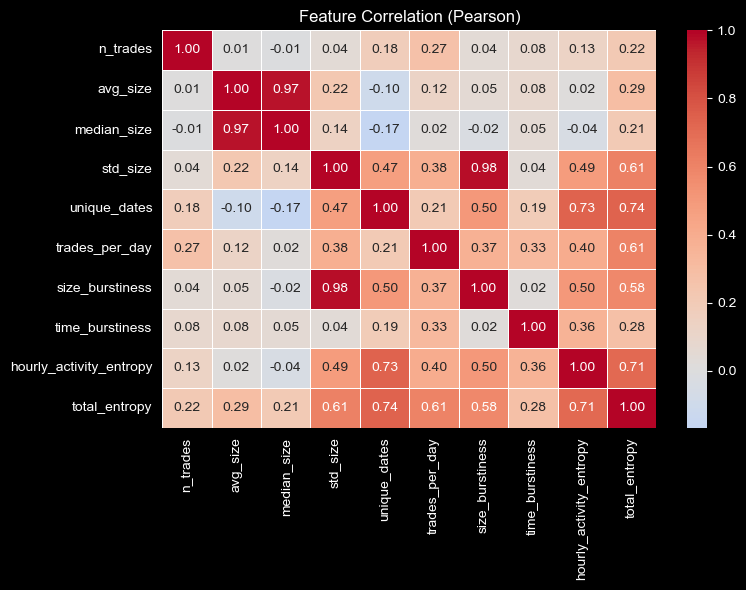

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson,
            annot=True,       # show correlation values
            cmap='coolwarm',  # color gradient
            center=0,         # white = no correlation
            linewidths=0.5,
            fmt=".2f")

plt.title("Feature Correlation (Pearson)")
plt.tight_layout()
plt.show()


In [23]:
features = df_features.columns
features = features.drop(["wallet_id", "n_trades", "std_size", "size_burstiness", "avg_size", "unique_dates"])

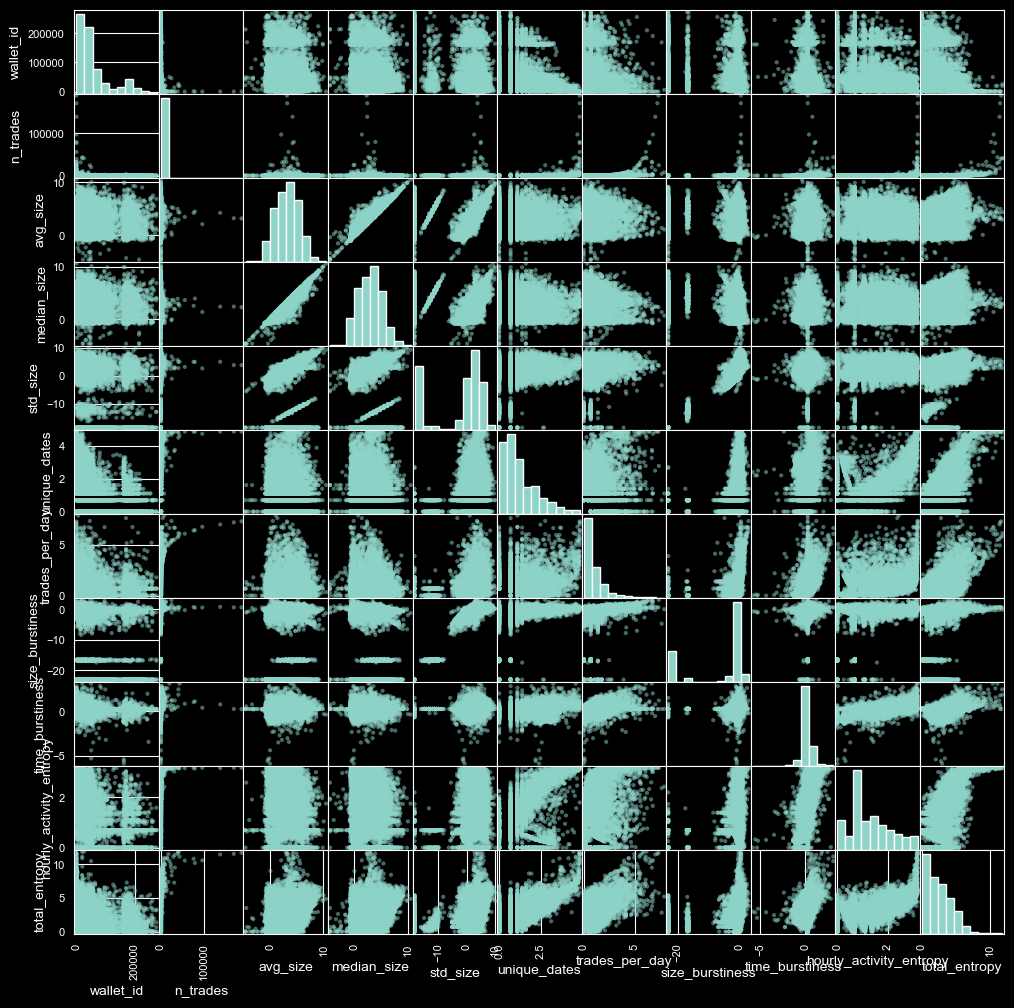

In [24]:
pd.plotting.scatter_matrix(df_features, figsize=(12, 12))
plt.show()

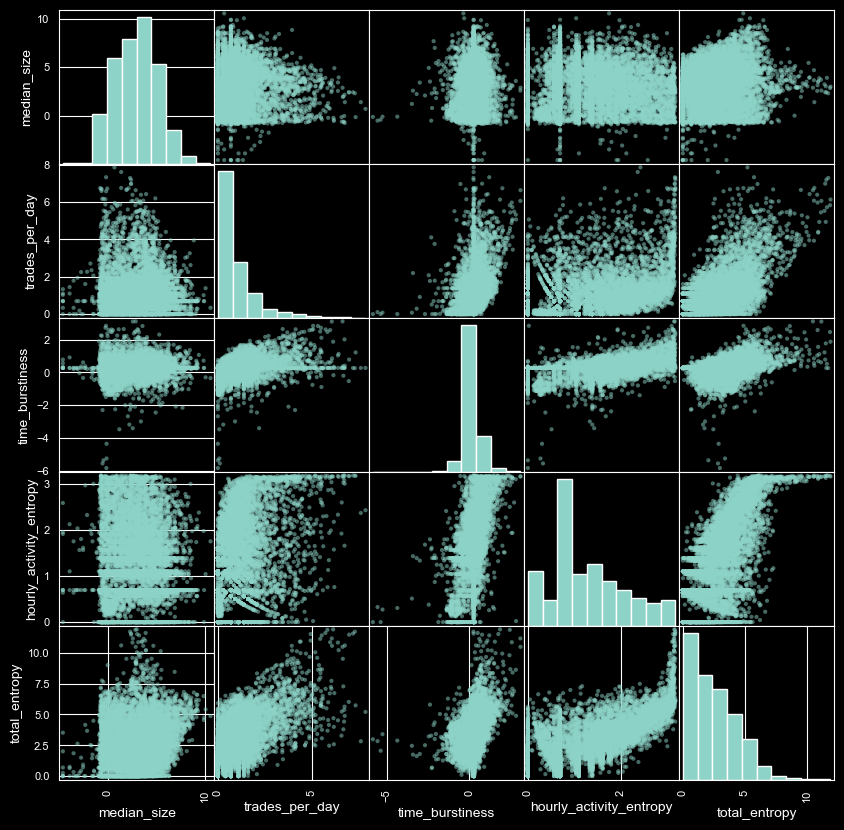

In [25]:
pd.plotting.scatter_matrix(df_features[features], figsize=(10, 10))
plt.show()

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def scale_and_reduce(X, n_components=2):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=42)
    Xp = pca.fit_transform(Xs)
    return Xs, Xp, scaler, pca

def run_kmeans(Xs, n_clusters=4, random_state=42):
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    labels = km.fit_predict(Xs)
    return km, labels

def run_dbscan(Xs, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(Xs)
    return db, labels

def cluster_summary(features_df, labels, label_name='cluster'):
    dfc = features_df.copy()
    dfc[label_name] = labels
    summary = dfc.groupby(label_name).agg(['count','mean','median']).transpose()
    return dfc, summary

def plot_pca(Xp, labels, title='PCA scatter of wallets', figsize=(8,6)):
    plt.figure(figsize=figsize)
    unique_labels = np.unique(labels)
    palette = plt.cm.get_cmap('tab10', len(unique_labels))
    for i, lab in enumerate(unique_labels):
        mask = labels == lab
        label_text = f'cluster {lab}' if lab != -1 else 'noise'
        plt.scatter(Xp[mask,0], Xp[mask,1], s=10, label=label_text, alpha=0.7)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(title)
    plt.legend(markerscale=2, fontsize=8)
    plt.grid(alpha=0.2)
    plt.show()

def radar_plot_centroids(features, labels, n_top_features=6):
    import math
    df = features.copy()
    df['cluster'] = labels
    centroids = df.groupby('cluster').median()
    # choose top features by variance across centroids (to plot distinguishing features)
    feat_vars = centroids.var(axis=0).sort_values(ascending=False)
    chosen = feat_vars.index[:n_top_features].tolist()
    # prepare radar
    N = len(chosen)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]  # close the circle
    fig, axes = plt.subplots(1, len(centroids), subplot_kw=dict(polar=True), figsize=(3*len(centroids), 4))
    if len(centroids) == 1:
        axes = [axes]
    for ax, (cluster_label, row) in zip(axes, centroids.iterrows()):
        values = row[chosen].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(chosen, fontsize=9)
        ax.set_title(f'cluster {cluster_label}', fontsize=10)
    plt.suptitle('Median feature profile per cluster (radar)', y=1.05)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main pipeline function
# -------------------------
def segment_wallets(df_features,
                    kmeans_k=4):

    chosen_features = [feature for feature in df_features.columns if feature != "wallet_id"]

    X = df_features[chosen_features].copy()
    X_drop = X.dropna()

    # scale & reduce for visualization
    Xs, Xp, scaler, pca = scale_and_reduce(X_drop, n_components=2)

    # KMeans
    km, km_labels = run_kmeans(Xs, n_clusters=kmeans_k)
    km_sil = silhouette_score(Xs, km_labels) if len(set(km_labels)) > 1 else np.nan
    print(f'KMeans k={kmeans_k} silhouette score: {km_sil:.4f}')

    # Summaries
    km_wallets, km_summary = cluster_summary(df_features, km_labels, label_name='kmeans_cluster')

    print('\nKMeans cluster counts:')
    print(km_wallets['kmeans_cluster'].value_counts())

    # Visualize
    plot_pca(Xp, km_labels, title=f'PCA scatter (KMeans k={kmeans_k})')

    # Radar chart for cluster medians (KMeans)
    radar_plot_centroids(df_features[chosen_features], km_labels, n_top_features=min(6, len(chosen_features)))

    # return results and artifacts
    out = {
        'features': df_features,
        'chosen_features': chosen_features,
        'X_imputed': X_drop,
        'scaler': scaler,
        'pca': pca,
        'pca_coords': pd.DataFrame(Xp, index=df_features.index, columns=['PC1','PC2']),
        'kmeans': {'model': km, 'labels': pd.Series(km_labels, index=df_features.index)},
        # 'dbscan': {'model': db, 'labels': pd.Series(db_labels, index=features.index)},
        'kmeans_summary': km_summary,
        # 'dbscan_summary': db_summary,
        'kmeans_silhouette': km_sil,
        # 'dbscan_silhouette': db_sil
    }
    return out

KMeans k=4 silhouette score: 0.2569

KMeans cluster counts:
kmeans_cluster
0    3737
2    2851
1    2038
3    1443
Name: count, dtype: int64


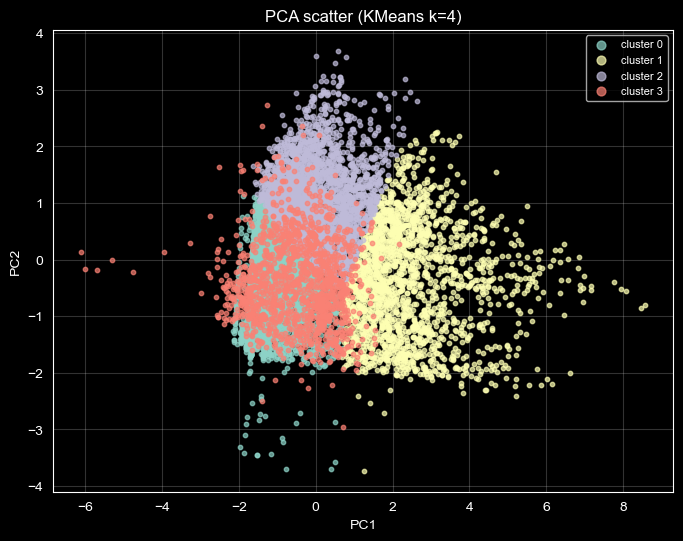

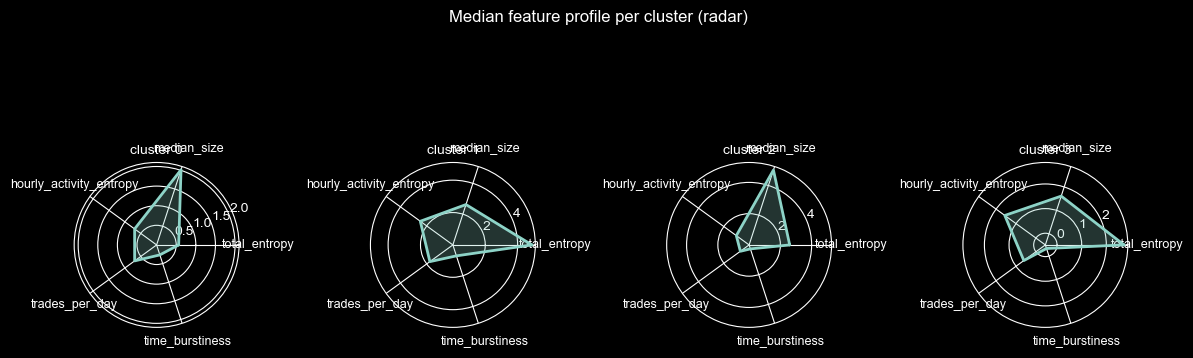

In [28]:
res = segment_wallets(df_features[features], kmeans_k=4)

In [29]:
cluster_stats = pd.concat([
    wallet_stats,
    res['kmeans']['labels'].rename('kmeans_cluster')
], axis=1)

In [30]:
cluster_stats

,wallet_id,n_trades,avg_size,median_size,std_size,unique_dates,trades_per_day,size_burstiness,time_burstiness,hourly_activity_entropy,total_entropy,kmeans_cluster
0,1,69,69.565216,47.049999,285.302948,2,34.500000,4.101230e+00,1.306593,0.769738,4.632475,1
1,3,3937,180.847824,84.989998,273.010529,66,59.651515,1.509615e+00,4.073870,3.005802,8.353945,1
2,5,2156,47.063908,23.395000,51.910038,67,32.179104,1.102969e+00,8.781987,3.111425,7.882136,1
3,6,3275,48.900211,19.040001,56.465569,97,33.762887,1.154710e+00,2.196128,3.115243,7.082325,1
4,7,5523,39.259502,12.320000,51.657661,121,45.644628,1.315800e+00,2.611751,3.132419,7.862364,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10064,271551,2,36.129997,36.129999,0.000003,1,2.000000,7.465814e-08,1.306593,0.693147,0.654575,0
10065,271895,12,53.143337,50.515001,18.827892,2,6.000000,3.542851e-01,1.152154,1.583258,3.151694,2
10066,272337,2,59.660004,59.660002,0.000003,2,1.000000,4.521284e-08,1.306593,0.693147,1.386270,0
10067,272404,2,959.900024,959.900024,0.000000,1,2.000000,0.000000e+00,1.306593,0.000000,3.277726,2


In [31]:
cluster_stats.groupby("kmeans_cluster").agg(
    wallets=("wallet_id", "count"),
    sum_trades=("n_trades", "sum"),
    avg_size=("avg_size", "mean"),
    std_size=("avg_size", "std"),
    avg_std=("std_size", "mean"),
    std_std=("std_size", "std"),
    std_time_burst=("time_burstiness", "std"),
    avg_time_burst=("time_burstiness", "mean"),
    std_size_burst=("size_burstiness", "std"),
    avg_size_burst=("size_burstiness", "mean"),
)

,wallets,sum_trades,avg_size,std_size,avg_std,std_std,std_time_burst,avg_time_burst,std_size_burst,avg_size_burst
kmeans_cluster,,,,,,,,,,
0,3737,13956,18.164688,24.624874,5.523814,21.547028,0.126009,1.320948,0.461387,0.302263
1,2038,2203812,140.676880,415.018005,188.922653,575.275330,1.692367,2.425902,1.654367,1.358509
2,2851,22752,536.361511,1491.756226,253.443207,971.217834,0.268647,1.319725,0.511503,0.531268
3,1443,24164,31.971315,102.271095,25.236977,81.969887,0.300052,0.742520,0.551290,0.681018


In [32]:
df_all

,wallet_id,time,is_ask,size,price,date,hour,date_hour,round_size
0,1,2025-06-30 19:16:16.060000+00:00,False,47.049999,18.014999,2025-06-30,19,2025-06-3019,47.05
1,1,2025-06-30 19:16:46.011000+00:00,False,47.049999,18.025000,2025-06-30,19,2025-06-3019,47.05
2,1,2025-06-30 19:17:17.005000+00:00,False,47.059998,18.030884,2025-06-30,19,2025-06-3019,47.06
3,1,2025-06-30 19:17:46.024000+00:00,False,47.049999,18.018999,2025-06-30,19,2025-06-3019,47.05
4,1,2025-06-30 19:18:16.077000+00:00,False,47.059998,18.011999,2025-06-30,19,2025-06-3019,47.06
...,...,...,...,...,...,...,...,...,...
2265245,272404,2025-06-23 16:40:53.219000+00:00,True,959.900024,16.377071,2025-06-23,16,2025-06-2316,959.90
2265246,272404,2025-06-23 16:45:39.769000+00:00,False,959.900024,16.470161,2025-06-23,16,2025-06-2316,959.90
2265247,274311,2025-06-15 15:19:18.194000+00:00,True,2.710000,19.183001,2025-06-15,15,2025-06-1515,2.71
2265248,274311,2025-06-15 17:27:03.505000+00:00,False,2.710000,19.049000,2025-06-15,17,2025-06-1517,2.71


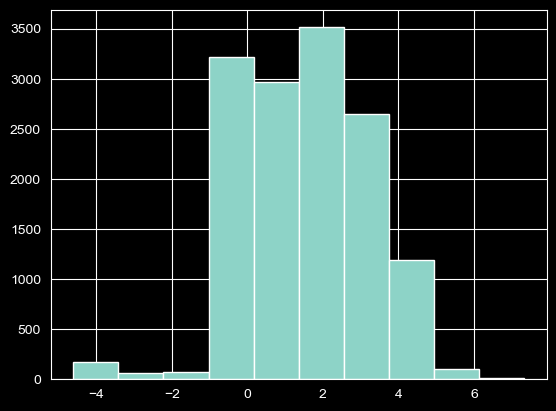

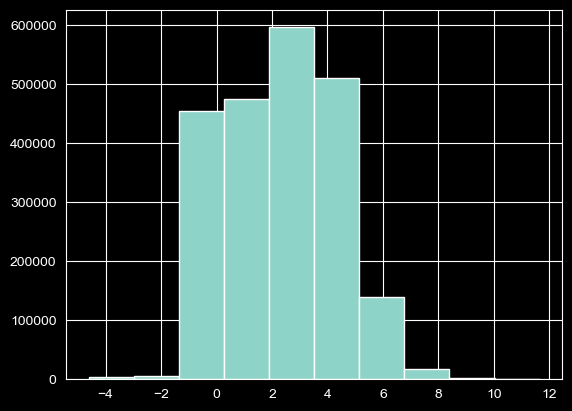

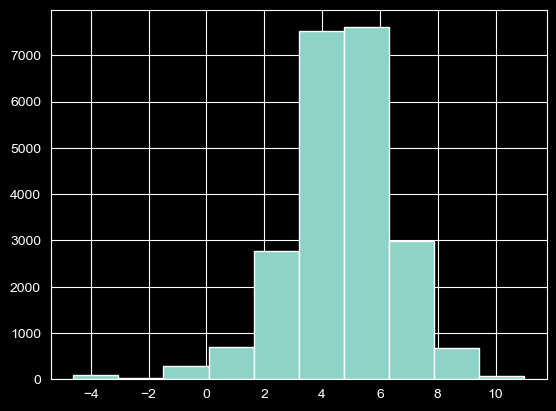

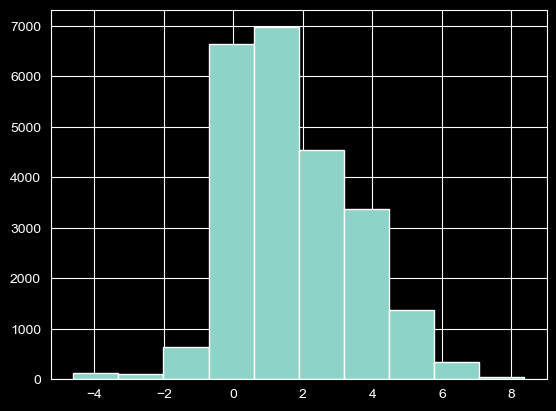

In [33]:
for cluster_id in range(4):
    cluster_wallets = cluster_stats[cluster_stats["kmeans_cluster"] == cluster_id]["wallet_id"]
    np.log(df_all[df_all["wallet_id"].isin(cluster_wallets)]["size"]).hist()
    plt.show()

In [37]:
time_diff_s = 5 * 60 # 5 minute difference
price_diff_pct = 0.01
size_diff_pct = 0.01
is_final_filtration=False

df_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, randomization=None, is_final_filtration=is_final_filtration)
df_detected

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,8,2025-03-22,2025-03-22 12:22:36.650,2025-03-22 12:25:59.450,202.80,buy,sell,19.433001,19.415001,0.000926,1.010000,1.010000,0.000000e+00,buy_to_sell,0
1,8,2025-03-22,2025-03-22 13:48:26.900,2025-03-22 13:49:26.300,59.40,buy,sell,19.362000,19.357000,0.000258,0.790000,0.790000,0.000000e+00,buy_to_sell,1
2,8,2025-03-22,2025-03-22 19:43:30.450,2025-03-22 19:46:45.400,194.95,sell,buy,19.658001,19.635002,0.001170,42.290001,42.529999,5.675050e-03,sell_to_buy,2
3,8,2025-03-22,2025-03-22 20:10:04.500,2025-03-22 20:10:51.100,46.60,sell,buy,19.652000,19.658001,0.000305,6.960000,6.950000,1.436814e-03,sell_to_buy,3
4,8,2025-03-22,2025-03-22 21:06:57.250,2025-03-22 21:06:57.350,0.10,buy,sell,19.582001,19.582001,0.000000,9.430000,9.410000,2.120939e-03,buy_to_sell,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38359,34432,2025-07-27,2025-07-27 05:07:53.500,2025-07-27 05:08:13.550,20.05,sell,buy,25.028000,25.020069,0.000317,50.000000,50.000000,0.000000e+00,sell_to_buy,38359
38360,75319,2025-07-27,2025-07-27 05:47:51.700,2025-07-27 05:51:09.050,197.35,buy,sell,25.157833,25.119278,0.001533,384.740021,384.739990,7.932000e-08,buy_to_sell,38360
38361,168961,2025-07-27,2025-07-27 00:36:43.650,2025-07-27 00:37:53.850,70.20,buy,sell,24.940001,24.930000,0.000401,0.640000,0.640000,0.000000e+00,buy_to_sell,38361
38362,172595,2025-07-27,2025-07-27 07:57:57.800,2025-07-27 07:59:34.200,96.40,sell,buy,25.021999,25.038002,0.000640,0.400000,0.400000,0.000000e+00,sell_to_buy,38362


In [38]:
h0_volume = (df_detected["open_size"] + df_detected["close_size"]).sum()
h0_count = df_detected["open_size"].shape[0]

In [42]:
sim = []

def block_and_side_permutation_optimized(df, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    df_perm = df.merge(cluster_stats[["wallet_id", "kmeans_cluster"]], on="wallet_id", how="left")

    def permute_column(x):
        return rng.permutation(x.values)

    df_perm["wallet_id"] = df_perm.groupby(["kmeans_cluster", "side"])["wallet_id"].transform(permute_column)

    out = df_perm.sort_values("time").drop(columns="kmeans_cluster")
    return out

In [49]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, block_and_side_permutation_optimized, is_final_filtration=is_final_filtration)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    sim.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.473		 - 1.463
1		 - 0.482		 - 1.472


### Geometric progression permutation

In [43]:
import numpy as np
import pandas as pd

def make_size_clusters_min_size(df, multiplier=1.5, min_cluster_size=15):
    # 1. median size per wallet
    sizes = (
        df.groupby("wallet_id")["size"].median()
          .sort_values()
          .rename("median_size")
    )

    wallet_ids = sizes.index.to_list()
    median_vals = sizes.values

    clusters = []
    current_cluster = []

    # first threshold: minimal median size
    threshold = median_vals[0] * multiplier

    for wallet, size in zip(wallet_ids, median_vals):
        current_cluster.append(wallet)

        # condition to start a new cluster:
        # 1) size passed threshold
        # 2) cluster has min size
        if size > threshold and len(current_cluster) >= min_cluster_size:
            clusters.append(current_cluster)

            # reset
            current_cluster = []
            threshold = size * multiplier

    # add final cluster
    if current_cluster:
        clusters.append(current_cluster)

    # Build result df
    rows = []
    for cid, wlts in enumerate(clusters):
        for w in wlts:
            rows.append((w, cid))

    out = pd.DataFrame(rows, columns=["wallet_id", "kmeans_cluster"])
    return out


In [44]:
cl = make_size_clusters_min_size(df_all, multiplier=1.5)
cluster_stats = pd.merge(
    wallet_stats,
    cl,
    on="wallet_id"
)

In [45]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, block_and_side_permutation_optimized, is_final_filtration=is_final_filtration)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    sim.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.627		 - 1.041
1		 - 0.637		 - 1.036


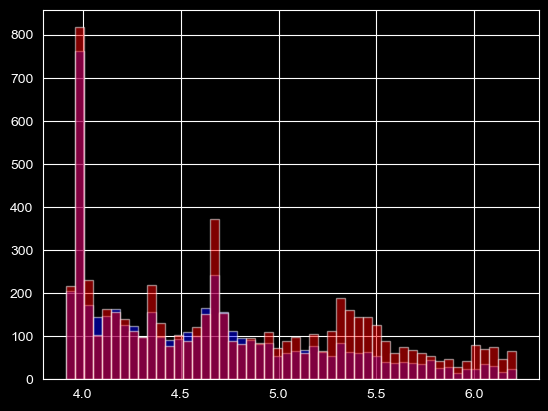

In [48]:
np.log(sim_time_detected[(sim_time_detected["open_size"] > 50) & (sim_time_detected["open_size"] < 500)]["open_size"]).hist(bins=50, alpha=0.5, color="blue", label="Permuted data")
np.log(df_detected[(df_detected["open_size"] > 50) & (df_detected["open_size"] < 500)]["open_size"]).hist(bins=50, alpha=0.5, color="red", label="Original data")
plt.show()

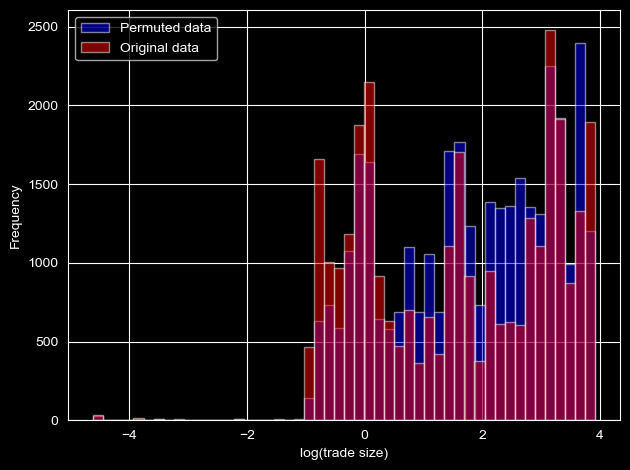

In [50]:
np.log(sim_time_detected[(sim_time_detected["open_size"] < 50)]["open_size"]).hist(bins=50, alpha=0.5, color="blue", label="Permuted data")
np.log(df_detected[(df_detected["open_size"] < 50)]["open_size"]).hist(bins=50, alpha=0.5, color="red", label="Original data")

plt.xlabel("log(trade size)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [230]:
df_perm = df_all.merge(cluster_stats[["wallet_id", "kmeans_cluster"]], on="wallet_id", how="left")
rng = np.random.default_rng()
def permute_column(x):
    return rng.permutation(x.values)
df_perm["wallet_id"] = df_perm.groupby(["kmeans_cluster", "is_ask"])["wallet_id"].transform(permute_column)
df_perm = df_perm.sort_values("time").drop(columns="kmeans_cluster")

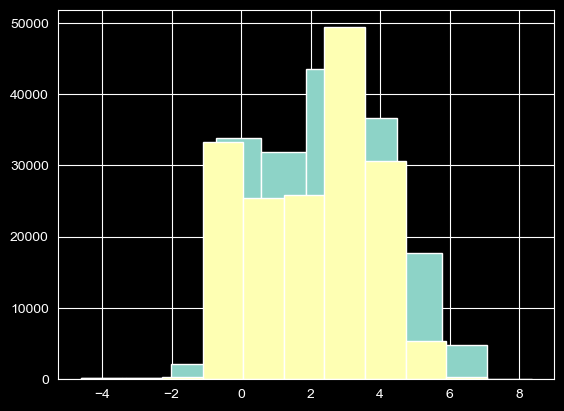

In [236]:
np.log(df_perm[df_perm["wallet_id"] == 8]["size"]).hist()
np.log(df_all[df_all["wallet_id"] == 8]["size"]).hist()
plt.show()

In [ ]:
np.log(df_detected[df_detected["wallet_id"] == 8]["open_size"]).hist(bins=20)

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_wallet_balance(df, wallet_id, start_date_str, n_days=7, shift_days=0):
    """
    Plot accumulated token balance for a wallet over a specific time window,
    keeping balance constant between trades (step-like timeline).
    """

    # Ensure time column is timezone-aware
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Define date window
    start_date = pd.to_datetime(start_date_str, utc=True) + pd.Timedelta(days=shift_days)
    end_date = start_date + pd.Timedelta(days=n_days)

    # Filter for wallet and date range
    mask = (df['wallet_id'] == wallet_id) & (df['time'].between(start_date, end_date))
    df_wallet = df.loc[mask].copy()

    if df_wallet.empty:
        print(f"No data found for wallet {wallet_id} between {start_date.date()} and {end_date.date()}.")
        return

    # Sort by time
    df_wallet = df_wallet.sort_values('time')

    # Compute signed size and cumulative balance
    df_wallet['signed_size'] = np.where(df_wallet['is_ask'], -df_wallet['size'], df_wallet['size'])
    df_wallet['balance'] = df_wallet['signed_size'].cumsum()

    # Add previous balance at start and fill forward to create step plot
    df_wallet = pd.concat([
        pd.DataFrame({'time': [start_date], 'balance': [0]}),
        df_wallet[['time', 'balance']]
    ]).sort_values('time')

    # Fill forward to show constant balance between trades
    df_wallet['balance'] = df_wallet['balance'].ffill()

    # Add last point to extend flat line to end_date
    df_wallet = pd.concat([
        df_wallet,
        pd.DataFrame({'time': [end_date], 'balance': [df_wallet['balance'].iloc[-1]]})
    ])

    # Plot as a step plot
    plt.figure(figsize=(10, 5))
    plt.step(df_wallet['time'], df_wallet['balance'], where='post', linewidth=2)
    plt.scatter(df_wallet['time'], df_wallet['balance'], color='white', s=20, zorder=3, alpha=0.7)
    plt.title(f"Token Balance Over Time (Step Plot)\nWallet: {wallet_id}\n{start_date.date()} → {end_date.date()}")
    plt.xlabel("Time")
    plt.ylabel("Token Balance")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df_wallet

In [85]:
i = 0

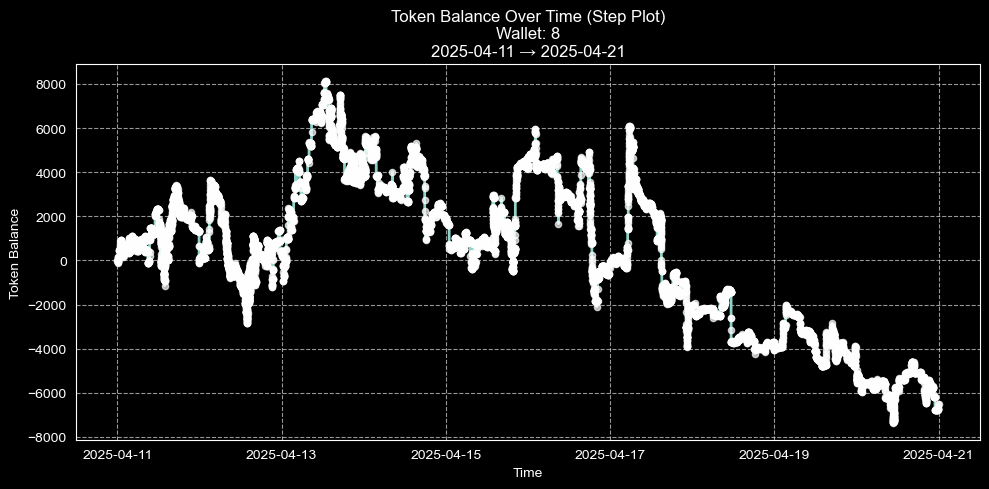

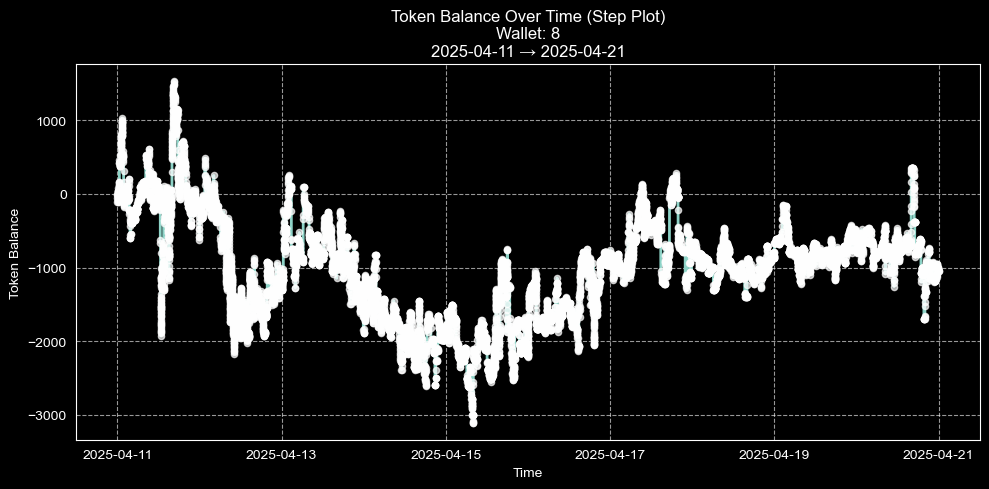

In [243]:
df_wallet = plot_wallet_balance(df_perm, 8, "2025-03-22", n_days=10, shift_days=10*i)
df_wallet = plot_wallet_balance(df_all, 8, "2025-03-22", n_days=10, shift_days=10*i)
i+=1

In [33]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd


def compute_nn_idx(wallet_features: pd.DataFrame, k: int):
    X = wallet_features.to_numpy()

    # pairwise squared distances
    D = ((X[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)
    np.fill_diagonal(D, np.inf)

    # nearest neighbors
    NN_idx = np.argsort(D, axis=1)[:, :k]
    return NN_idx


def trade_level_nn_permutation(
    df: pd.DataFrame,
    wallet_features: pd.DataFrame,
    NN_idx: np.ndarray,
    k0: int
):
    rng = np.random.default_rng()

    wallet_ids = wallet_features.index.to_numpy()
    w2i = {w: i for i, w in enumerate(wallet_ids)}
    i2w = wallet_ids
    n_wallets = len(wallet_ids)

    buyer_i  = df["buyer"].map(w2i).to_numpy()
    seller_i = df["seller"].map(w2i).to_numpy()
    time_arr = df["time"].to_numpy()

    cap_buy  = np.zeros(n_wallets, dtype=int)
    cap_sell = np.zeros(n_wallets, dtype=int)

    np.add.at(cap_buy,  buyer_i,  1)
    np.add.at(cap_sell, seller_i, 1)

    active_buy  = cap_buy  > 0
    active_sell = cap_sell > 0

    buyer_p  = buyer_i.copy()
    seller_p = seller_i.copy()

    # Process trades in time order
    order = np.argsort(time_arr)
    count = 0

    for t in tqdm(order):
        b0 = buyer_i[t]
        s0 = seller_i[t]

        max_tries = 10
        step = 2

        # ---- buyer reassignment ----
        nbrs_b = NN_idx[b0][:k0]
        cand_b = nbrs_b[active_buy[nbrs_b]]

        if cand_b.size == 0:
            cand_b = np.flatnonzero(active_buy)

        weights_b = cap_buy[cand_b]
        b_new = rng.choice(cand_b, p=weights_b / weights_b.sum())

        # ---- seller reassignment with adaptive expansion ----
        tries = 0
        k_cur = k0

        while True:
            nbrs_s = NN_idx[s0][:k_cur]
            cand_s = nbrs_s[active_sell[nbrs_s]]

            if cand_s.size == 0:
                cand_s = np.flatnonzero(active_sell)

            weights_s = cap_sell[cand_s]
            s_new = rng.choice(cand_s, p=weights_s / weights_s.sum())

            if b_new != s_new or tries >= max_tries:
                if tries >= max_tries:
                    count += 1
                break

            tries += 1
            k_cur = min(k_cur + step, NN_idx.shape[1])


        # assign
        buyer_p[t]  = b_new
        seller_p[t] = s_new

        # update capacities
        cap_buy[b_new]  -= 1
        cap_sell[s_new] -= 1

        if cap_buy[b_new] == 0:
            active_buy[b_new] = False
        if cap_sell[s_new] == 0:
            active_sell[s_new] = False

    df_perm = df.copy()
    df_perm["buyer"]  = i2w[buyer_p]
    df_perm["seller"] = i2w[seller_p]

    print(count)

    return df_perm

In [34]:
dfam = df_all_matched[(df_all_matched["buyer"].isin(df_features["wallet_id"])) & (df_all_matched["seller"].isin(df_features["wallet_id"]))]

In [35]:
dff = df_features.set_index("wallet_id")[features]

In [36]:
time_diff_s = 5 * 60 # 5 minute difference
price_diff_pct = 0.01
size_diff_pct = 0.01
is_final_filtration=False

df_detected = detect_wash_trades_local(dfam, time_diff_s, price_diff_pct, size_diff_pct, randomization=None, is_final_filtration=is_final_filtration)
df_detected

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,8,2025-03-22,2025-03-22 12:22:36.650,2025-03-22 12:25:59.450,202.80,buy,sell,19.433001,19.415001,0.000926,1.010000,1.010000,0.000000e+00,buy_to_sell,0
1,8,2025-03-22,2025-03-22 13:48:26.900,2025-03-22 13:49:26.300,59.40,buy,sell,19.362000,19.357000,0.000258,0.790000,0.790000,0.000000e+00,buy_to_sell,1
2,8,2025-03-22,2025-03-22 19:43:30.450,2025-03-22 19:46:45.400,194.95,sell,buy,19.658001,19.635002,0.001170,42.290001,42.529999,5.675050e-03,sell_to_buy,2
3,8,2025-03-22,2025-03-22 20:10:04.500,2025-03-22 20:10:51.100,46.60,sell,buy,19.652000,19.658001,0.000305,6.960000,6.950000,1.436814e-03,sell_to_buy,3
4,8,2025-03-22,2025-03-22 21:06:57.250,2025-03-22 21:06:57.350,0.10,buy,sell,19.582001,19.582001,0.000000,9.430000,9.410000,2.120939e-03,buy_to_sell,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38345,34432,2025-07-27,2025-07-27 05:07:53.500,2025-07-27 05:08:13.550,20.05,sell,buy,25.028000,25.020069,0.000317,50.000000,50.000000,0.000000e+00,sell_to_buy,38345
38346,75319,2025-07-27,2025-07-27 05:47:51.700,2025-07-27 05:51:09.050,197.35,buy,sell,25.157833,25.119278,0.001533,384.740021,384.739990,7.932000e-08,buy_to_sell,38346
38347,168961,2025-07-27,2025-07-27 00:36:43.650,2025-07-27 00:37:53.850,70.20,buy,sell,24.940001,24.930000,0.000401,0.640000,0.640000,0.000000e+00,buy_to_sell,38347
38348,172595,2025-07-27,2025-07-27 07:57:57.800,2025-07-27 07:59:34.200,96.40,sell,buy,25.021999,25.038002,0.000640,0.400000,0.400000,0.000000e+00,sell_to_buy,38348


In [37]:
h0_volume = (df_detected["open_size"] + df_detected["close_size"]).sum()
h0_count = df_detected["open_size"].shape[0]

In [38]:
# sim = []

In [90]:
print(f"number\t - volume share\t - count share")
NN_idx = compute_nn_idx(dff, k=20)

for i in range(10):
    dfam_perm = trade_level_nn_permutation(dfam, dff, NN_idx, 6)
    sim_time_detected = detect_wash_trades_local(dfam_perm, time_diff_s, price_diff_pct, size_diff_pct, randomization=None, is_final_filtration=is_final_filtration)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    sim.append(sim_time_detected)

    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share


  0%|          | 0/1477093 [00:00<?, ?it/s]

363
0		 - 0.311		 - 0.744


  0%|          | 0/1477093 [00:00<?, ?it/s]

365
1		 - 0.299		 - 0.732


  0%|          | 0/1477093 [00:00<?, ?it/s]

396
2		 - 0.309		 - 0.743


  0%|          | 0/1477093 [00:00<?, ?it/s]

358
3		 - 0.318		 - 0.738


  0%|          | 0/1477093 [00:00<?, ?it/s]

374
4		 - 0.303		 - 0.730


  0%|          | 0/1477093 [00:00<?, ?it/s]

365
5		 - 0.314		 - 0.732


  0%|          | 0/1477093 [00:00<?, ?it/s]

375
6		 - 0.310		 - 0.737


  0%|          | 0/1477093 [00:00<?, ?it/s]

419
7		 - 0.314		 - 0.739


  0%|          | 0/1477093 [00:00<?, ?it/s]

386
8		 - 0.306		 - 0.735


  0%|          | 0/1477093 [00:00<?, ?it/s]

373
9		 - 0.313		 - 0.741


In [40]:
def flatten_trades(df_all_matched):
    sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
    sells["is_ask"] = True

    buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
    buys["is_ask"] = False

    df_all = pd.concat([sells, buys], ignore_index=True)

    df_all["notional"] = df_all["price"] * df_all["size"]
    df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
    df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
    return df_all.drop("notional", axis=1)

In [41]:
NN_idx = compute_nn_idx(dff, k=20)
dfamp = trade_level_nn_permutation(dfam, dff, NN_idx, 8)

  0%|          | 0/1477093 [00:00<?, ?it/s]

21


In [42]:
dfamf = flatten_trades(dfam)
dfampf = flatten_trades(dfamp)

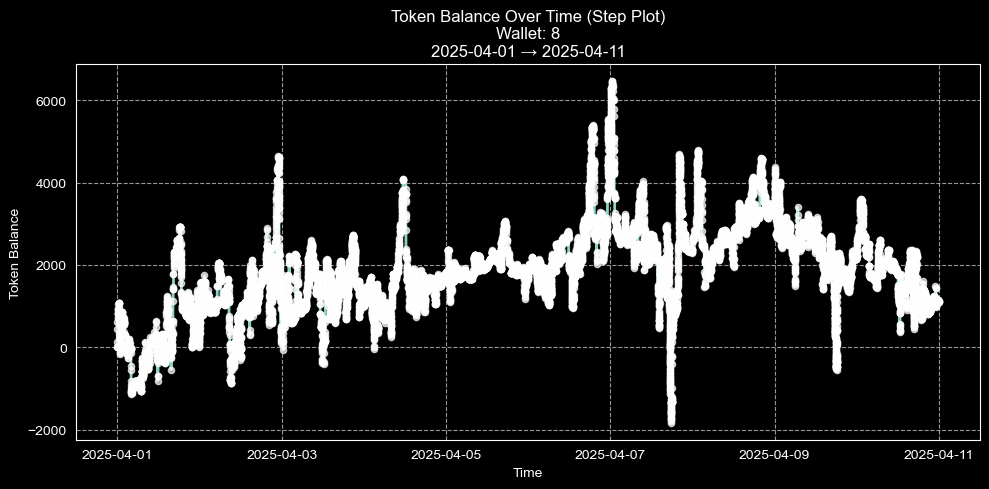

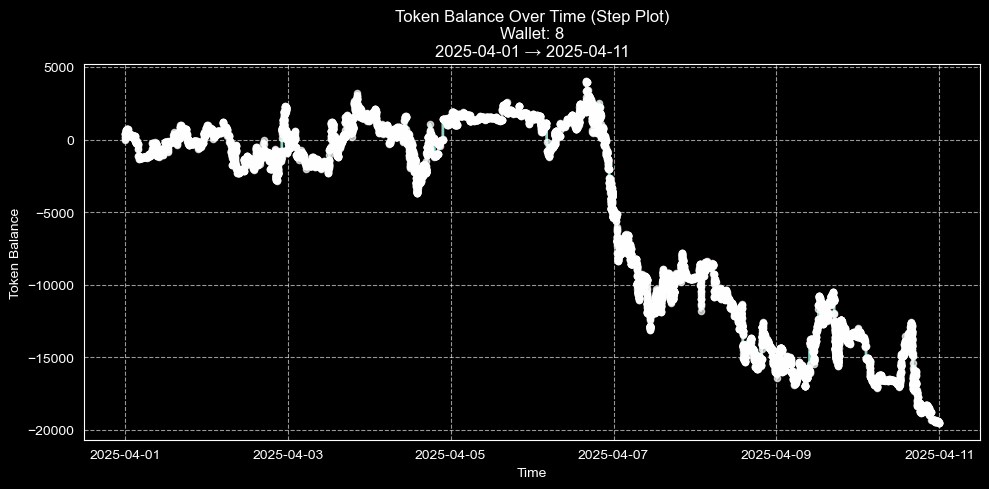

In [52]:
df_wallet = plot_wallet_balance(dfamf, 8, "2025-03-22", n_days=10, shift_days=10*i)
df_walletp = plot_wallet_balance(dfampf, 8, "2025-03-22", n_days=10, shift_days=10*i)
i+=1

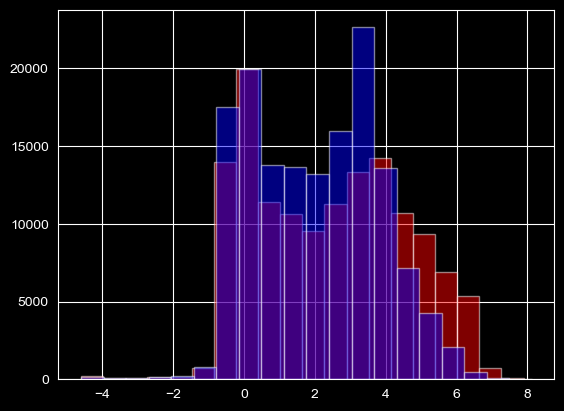

In [53]:
np.log(dfamf[dfamf["wallet_id"] == 161]["size"]).hist(bins=20, alpha=0.5, color="red")
np.log(dfampf[dfampf["wallet_id"] == 161]["size"]).hist(bins=20, alpha=0.5, color="blue")
plt.show()

In [54]:
rng = np.random.default_rng()

df_perm = dfam.copy()
df_perm["buyer"] = rng.permutation(df_perm["buyer"].to_numpy())
df_perm["seller"] = rng.permutation(df_perm["seller"].to_numpy())

In [55]:
import numpy as np
import pandas as pd

# wallet feature matrix
X = (
    df_features
    .set_index("wallet_id")[features]
)

# mapping wallet_id -> row index
wallet_ids = X.index.to_numpy()
w2i = {w: i for i, w in enumerate(wallet_ids)}

X_mat = X.to_numpy()


In [56]:
def compute_D2(df_orig, df_perm, role):
    """
    role: 'buyer' or 'seller'
    """
    idx_orig = df_orig[role].map(w2i).to_numpy().astype(int)
    idx_perm = df_perm[role].map(w2i).to_numpy().astype(int)

    diffs = X_mat[idx_orig] - X_mat[idx_perm]
    D2 = np.mean(np.sum(diffs**2, axis=1))

    return D2


In [57]:
D2_unif_buyer  = compute_D2(
    dfam,
    df_perm,
    role="buyer"
)

D2_unif_seller = compute_D2(
    dfam,
    df_perm,
    role="seller"
)


In [58]:
D2_nn_buyer  = compute_D2(
    dfam,
    dfamp,
    role="buyer"
)

D2_nn_seller = compute_D2(
    dfam,
    dfamp,
    role="seller"
)


In [59]:
print("Uniform buyer RMS distance:", np.sqrt(D2_unif_buyer))
print("Uniform seller RMS distance:", np.sqrt(D2_unif_seller))

print("NN buyer RMS distance:", np.sqrt(D2_nn_buyer))
print("NN seller RMS distance:", np.sqrt(D2_nn_seller))


Uniform buyer RMS distance: 5.282900054784913
Uniform seller RMS distance: 5.151024611344964
NN buyer RMS distance: 2.1951270227668784
NN seller RMS distance: 2.0630690201950004


In [91]:
Tvol_perm = np.empty(len(sim))
Tcnt_perm = np.empty(len(sim))


for i, simulation in enumerate(sim):
    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count

    Tvol_perm[i] = sim_time_detected_share_volume
    Tcnt_perm[i] = sim_time_detected_share_count

# 3) Right-tailed p-values (typical)
p_vol = (1 + np.sum(Tvol_perm >= 1)) / (len(sim) + 1)
p_cnt = (1 + np.sum(Tcnt_perm >= 1)) / (len(sim) + 1)

print("Observed volume-share:", h0_volume, "p-value:", p_vol)
print("Observed count-share :", h0_count, "p-value:", p_cnt)


Observed volume-share: 4735049.5 p-value: 0.018867924528301886
Observed count-share : 38350 p-value: 0.018867924528301886


In [92]:
df_sim_perm_res_list = list()

for i, simulation in enumerate(sim):
    df_volumes = pd.concat([
        simulation
        .groupby("wallet_id")[["open_size", "close_size"]]
        .sum()
        .sum(axis=1),

        df_detected
        .groupby("wallet_id")[["open_size", "close_size"]]
        .sum()
        .sum(axis=1)
    ], axis=1).fillna(0).rename({0: "perm_volume", 1: "real_volume"}, axis=1)

    df_sim_perm_res_list.append(df_volumes["perm_volume"] >= df_volumes["real_volume"])

In [96]:
df_sim_perm_res = pd.concat(df_sim_perm_res_list, axis=1).sum(axis=1)
wallet_perm = (1 + df_sim_perm_res) / (len(sim) + 1)

In [99]:
df_detected

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,8,2025-03-22,2025-03-22 12:22:36.650,2025-03-22 12:25:59.450,202.80,buy,sell,19.433001,19.415001,0.000926,1.010000,1.010000,0.000000e+00,buy_to_sell,0
1,8,2025-03-22,2025-03-22 13:48:26.900,2025-03-22 13:49:26.300,59.40,buy,sell,19.362000,19.357000,0.000258,0.790000,0.790000,0.000000e+00,buy_to_sell,1
2,8,2025-03-22,2025-03-22 19:43:30.450,2025-03-22 19:46:45.400,194.95,sell,buy,19.658001,19.635002,0.001170,42.290001,42.529999,5.675050e-03,sell_to_buy,2
3,8,2025-03-22,2025-03-22 20:10:04.500,2025-03-22 20:10:51.100,46.60,sell,buy,19.652000,19.658001,0.000305,6.960000,6.950000,1.436814e-03,sell_to_buy,3
4,8,2025-03-22,2025-03-22 21:06:57.250,2025-03-22 21:06:57.350,0.10,buy,sell,19.582001,19.582001,0.000000,9.430000,9.410000,2.120939e-03,buy_to_sell,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38345,34432,2025-07-27,2025-07-27 05:07:53.500,2025-07-27 05:08:13.550,20.05,sell,buy,25.028000,25.020069,0.000317,50.000000,50.000000,0.000000e+00,sell_to_buy,38345
38346,75319,2025-07-27,2025-07-27 05:47:51.700,2025-07-27 05:51:09.050,197.35,buy,sell,25.157833,25.119278,0.001533,384.740021,384.739990,7.932000e-08,buy_to_sell,38346
38347,168961,2025-07-27,2025-07-27 00:36:43.650,2025-07-27 00:37:53.850,70.20,buy,sell,24.940001,24.930000,0.000401,0.640000,0.640000,0.000000e+00,buy_to_sell,38347
38348,172595,2025-07-27,2025-07-27 07:57:57.800,2025-07-27 07:59:34.200,96.40,sell,buy,25.021999,25.038002,0.000640,0.400000,0.400000,0.000000e+00,sell_to_buy,38348


In [112]:
df_detected[df_detected["wallet_id"].isin(wallet_perm[wallet_perm > 0.05].index)]["wallet_id"].value_counts()

wallet_id
19        1112
8          967
4272       632
22         611
30         501
          ... 
57058        1
194292       1
16792        1
21951        1
178577       1
Name: count, Length: 354, dtype: int64